In [3]:
import torch
from pytorch_pretrained_biggan import BigGAN, truncated_noise_sample
from torchvision import models
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.nn as nn


In [4]:
# -------------------------------
# 1. Load Models
# -------------------------------
gan_model = BigGAN.from_pretrained("biggan-deep-256")
gan_model.eval()  # BigGAN in eval mode

scoring_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT).eval()  # ResNet for classification


100%|██████████| 715/715 [00:00<00:00, 1747626.67B/s]
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/kierangivens/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:02<00:00, 16.0MB/s]


In [5]:
# -------------------------------
# 2. Image Preprocessing
# The images generated by BigGAN are 256×256, 
# but ResNet18 expects input images to be 224×224.
# Use interpolate since its differentiable
# -------------------------------
def resnet_preprocess(img_tensor):
    """
    Resize and normalize an image tensor for ResNet.
    Expects img_tensor in [0, 1] range.
    """
    # Resize to 224x224 (differentiable using bilinear interpolation)
    img_tensor = F.interpolate(img_tensor, size=(224, 224), mode='bilinear', align_corners=False)
    # Normalize using ImageNet statistics
    mean = torch.tensor([0.485, 0.456, 0.406], device=img_tensor.device).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225], device=img_tensor.device).view(1, 3, 1, 1)
    img_tensor = (img_tensor - mean) / std
    return img_tensor


In [6]:
# -------------------------------
# 3. Set Up Class Conditioning
# this is the CF step
# -------------------------------
# Start with Golden Retriever (class 207) for generation.
# Our target for the counterfactual is Labrador Retriever (class 208).
initial_class = 207  # Golden Retriever for generation
target_class = 208   # Target: Labrador Retriever

# The generator (BigGAN) is conditioned on the initial class.
class_vector = torch.zeros((1, 1000))
class_vector[0, initial_class] = 1


In [ ]:
# -------------------------------
# 4. Set Up Latent Vector and Optimizer
# this is what's updated
# -------------------------------
truncation = 0.4
latent_vector = torch.tensor(
    truncated_noise_sample(truncation=truncation, batch_size=1, dim_z=128),
    dtype=torch.float32, requires_grad=True
)

learning_rate = 0.03  # A lower learning rate for more stable updates
optimizer = torch.optim.Adam([latent_vector], lr=learning_rate)

# Use CrossEntropyLoss to encourage the image to be classified as the target.
criterion = nn.CrossEntropyLoss()
target_label = torch.tensor([target_class], device=latent_vector.device)


Step 1/100 | Loss: 0.0125 | Predicted: 208


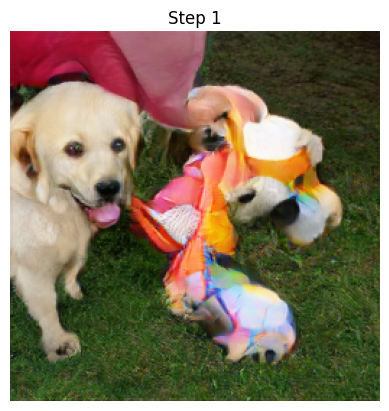

Step 11/100 | Loss: 0.0123 | Predicted: 208


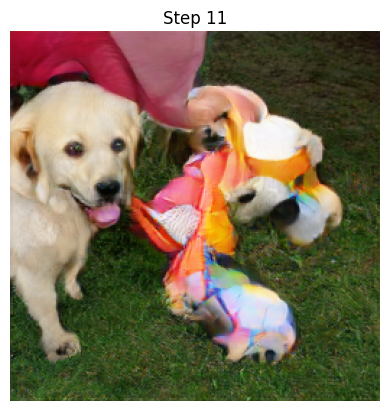

Step 21/100 | Loss: 0.0123 | Predicted: 208


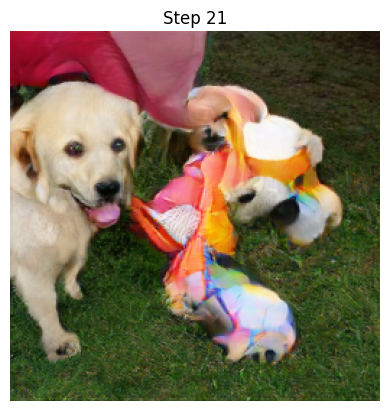

Step 31/100 | Loss: 0.0124 | Predicted: 208


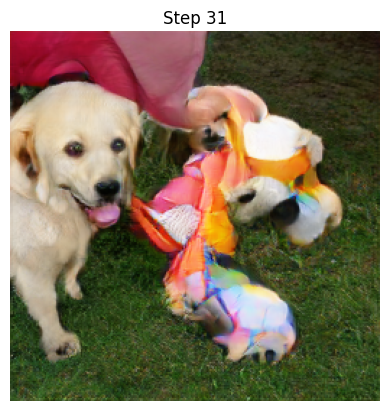

Step 41/100 | Loss: 0.0121 | Predicted: 208


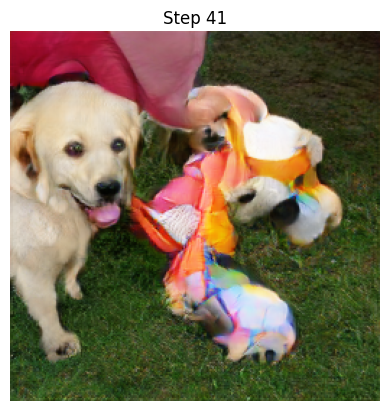

Step 51/100 | Loss: 0.0118 | Predicted: 208


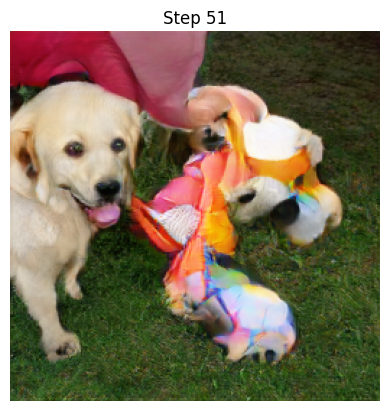

Step 61/100 | Loss: 0.0117 | Predicted: 208


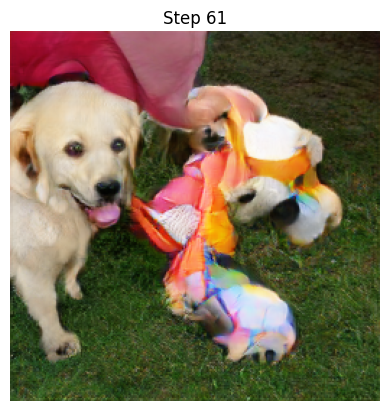

Step 71/100 | Loss: 0.0116 | Predicted: 208


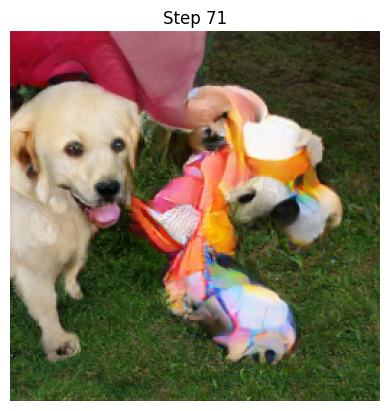

Step 81/100 | Loss: 0.0116 | Predicted: 208


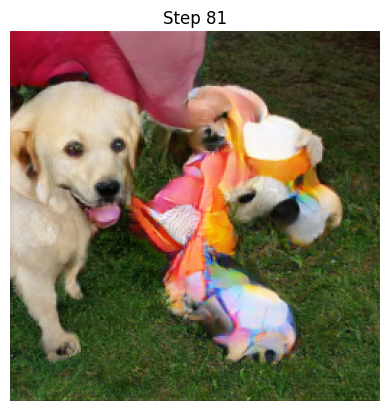

Step 91/100 | Loss: 0.0113 | Predicted: 208


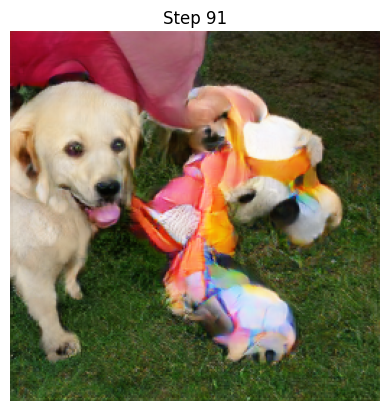

Step 100/100 | Loss: 0.0113 | Predicted: 208


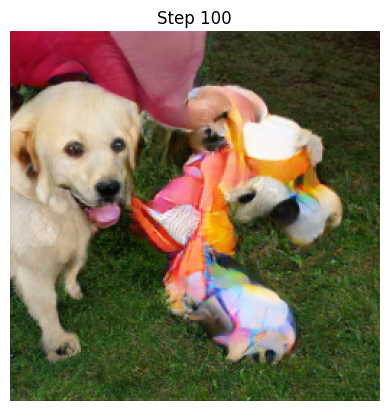

In [12]:
# -------------------------------
# 5. Optimization Loop
# -------------------------------
num_steps = 100
for step in range(num_steps):
    optimizer.zero_grad()
    
    # Generate image conditioned on the initial class (207)
    generated = gan_model(latent_vector, class_vector, truncation)
    # BigGAN outputs images in [-1, 1]; scale to [0, 1]
    img_tensor = (generated + 1) / 2

    # Preprocess the image for ResNet (differentiable)
    input_tensor = resnet_preprocess(img_tensor)
    
    # Forward pass through ResNet to get logits
    output = scoring_model(input_tensor)
    
    # Compute the loss against the target class (208)
    g_loss = criterion(output, target_label)
    
    # Backpropagate and update latent_vector
    g_loss.backward()
    optimizer.step()
    
    if step % 10 == 0 or step == num_steps - 1:
        # Log the current predicted class from ResNet
        _, predicted = output.max(1)
        print(f"Step {step+1}/{num_steps} | Loss: {g_loss.item():.4f} | Predicted: {predicted.item()}")
        
        # For visualization: detach and convert to numpy image
        img_disp = img_tensor.detach().cpu().squeeze().permute(1, 2, 0).clamp(0, 1).numpy()
        plt.imshow(img_disp)
        plt.title(f"Step {step+1}")
        plt.axis("off")
        plt.show()
